# Graph Deep Learning on Graph to study Fake News

In [2]:
!pip install dgl

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00


In [3]:
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch.nn.modules import Linear
from torch_geometric.transforms import ToUndirected
from torch.functional import F
import torch
import argparse
import os.path as osp


The dataset is initialized there. Note that:
- `bert` is the result of a transformer on average tweeets of the author and other info from him/her (as in our article)
- `profile` (user profile info such as number of tweets, followers, and join date)
- `dataset` is either `politifact` or `gossipcop`

Hence this is the same datas as our article except that I struggle to understand their "Network and relations" embedding in our original paper: isn't it already in the edges in a message-passing strategy ?

In [ ]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import UPFD
import os.path as osp
import torch

# Paths and settings
_file_ = '..'
file = _file_
dataset = 'gossipcop'  # or 'politifact'
path = osp.join(osp.dirname(osp.realpath(file)), '..', 'data', 'UPFD')

# Load datasets with bert and profile features separately
train_dataset_bert = UPFD(path, dataset, 'bert', 'train')
train_dataset_profile = UPFD(path, dataset, 'profile', 'train')

val_dataset_bert = UPFD(path, dataset, 'bert', 'val')
val_dataset_profile = UPFD(path, dataset, 'profile', 'val')

test_dataset_bert = UPFD(path, dataset, 'bert', 'test')
test_dataset_profile = UPFD(path, dataset, 'profile', 'test')

# Check that both datasets are aligned
assert len(train_dataset_bert) == len(train_dataset_profile)
assert len(val_dataset_bert) == len(val_dataset_profile)
assert len(test_dataset_bert) == len(test_dataset_profile)

# Function to combine features
def combine_features(dataset_bert, dataset_profile):
    combined_data = []
    for data_bert, data_profile in zip(dataset_bert, dataset_profile):
        data_bert.x = torch.cat([data_bert.x, data_profile.x], dim=-1)  # Concatenate features
        combined_data.append(data_bert)
    return combined_data

# Combine features for train, val, and test datasets

train_dataset = combine_features(train_dataset_bert, train_dataset_profile)
val_dataset = combine_features(val_dataset_bert, val_dataset_profile)
test_dataset = combine_features(test_dataset_bert, test_dataset_profile)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # In the article they use a batch size of 1 but we do not have the power to do it (it takes too much time).
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print(len(train_dataset) + len(val_dataset) + len(test_dataset))

5464


/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
print(train_dataset_bert[0].x.shape)
print(sum([e.x.shape[0] for e in train_dataset_bert[0:128] ]))
for e in train_loader:
    s = [0 for i in range(128)]
    for k in e.batch:
        s[k]+=1
    print(s)
    break

torch.Size([76, 768])
6883
[63, 82, 51, 53, 66, 152, 8, 72, 26, 91, 152, 18, 78, 85, 9, 51, 11, 71, 18, 12, 32, 76, 44, 19, 28, 31, 49, 14, 189, 144, 51, 20, 82, 92, 79, 23, 6, 60, 142, 6, 12, 95, 23, 33, 183, 49, 55, 50, 107, 77, 56, 37, 96, 70, 6, 186, 13, 182, 66, 45, 145, 86, 55, 139, 21, 123, 12, 21, 110, 48, 5, 125, 64, 12, 133, 76, 16, 10, 77, 31, 59, 18, 36, 85, 21, 124, 86, 5, 9, 9, 167, 139, 72, 76, 91, 19, 47, 136, 55, 57, 20, 78, 53, 16, 113, 71, 20, 17, 11, 117, 58, 74, 94, 45, 56, 41, 10, 23, 73, 79, 12, 11, 9, 83, 96, 7, 45, 13]


In [18]:
print(train_dataset_bert)
print(train_dataset[0].y)
print(train_dataset[0].x)
print(train_dataset[0].edge_index)
#train_dataset[i] représente l'arbre i
#Le champ x représente la valeur des noeud, il est de taille (n, 778).
#Le champ edge index représente les connexion dans l'abre. Il est de taille (2, n - 1). edge_index[0][i] est
#le père de edge_index[1][i]. En pratique, il se trouve que edge_index[1][i] est toujours un linespace, ce qui est possible
#Le champ y représente si c'est un graphe de fake news ou pas

UPFD(1092, name=gossipcop, feature=bert)
tensor([0])
tensor([[-0.0848, -0.2643, -0.2449,  ...,  0.6794,  0.1175,  0.1534],
        [ 0.1415, -0.0493, -0.1443,  ...,  0.0890,  0.1111,  0.1324],
        [-0.0319,  0.0562,  0.4386,  ...,  0.4658,  0.1667,  0.1765],
        ...,
        [ 0.0231,  0.1641,  0.0682,  ...,  0.8904,  0.1111,  0.0588],
        [-0.0714,  0.1860,  0.1526,  ...,  0.6233,  0.2222,  0.3529],
        [ 0.0569,  0.1775,  0.1596,  ...,  0.7740,  0.1111,  0.2500]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1, 70, 74],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
     

### Model

In [ ]:
class Net(torch.nn.Module):
    """
    This is the same model as the article. They do not specify the dimensions of hidden channels so this is our choice.
    They do not specify the convolution method,  GCN seems to be the best.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, concat=False):
        super().__init__()
        self.concat = concat
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv1 = GATConv(in_channels, hidden_channels)
        #self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.mean_pooling = global_mean_pool
        self.lin1 = Linear(hidden_channels, 2 * hidden_channels)
        self.lin2 = Linear(2*hidden_channels,2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.mean_pooling(x, batch)
        x = torch.nn.functional.selu(x)
        x = self.lin1(x)
        x = torch.nn.functional.selu(x)
        x = self.lin2(x)
        return x.softmax(dim=-1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(778, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.01,amsgrad=True) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
loss_fn = torch.nn.HingeEmbeddingLoss() # They specify that they want  the HingeEmbeddingLoss so we used it. 
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        y = torch.tensor([[1,0] if e==1 else [0,1] for e in data.y]).to(device)
        loss = loss_fn(out,y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

In [37]:
@torch.no_grad()
def test(loader, model):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        total_correct += int((pred ==
         data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

In [38]:
for epoch in range(1, 200):
    loss = train(model)
    train_acc = test(train_loader, model)
    val_acc = test(val_loader, model)
    test_acc = test(test_loader, model)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7501, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7423, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7349, Train: 0.6886, Val: 0.6703, Test: 0.6722
Epoch: 04, Loss: 0.7193, Train: 0.6603, Val: 0.6685, Test: 0.6560
Epoch: 05, Loss: 0.6903, Train: 0.7152, Val: 0.7125, Test: 0.6981
Epoch: 06, Loss: 0.6766, Train: 0.7344, Val: 0.7289, Test: 0.7091
Epoch: 07, Loss: 0.6517, Train: 0.7628, Val: 0.7546, Test: 0.7394
Epoch: 08, Loss: 0.6359, Train: 0.7592, Val: 0.7418, Test: 0.7342
Epoch: 09, Loss: 0.6255, Train: 0.7885, Val: 0.7802, Test: 0.7517
Epoch: 10, Loss: 0.6252, Train: 0.7857, Val: 0.7692, Test: 0.7517
Epoch: 11, Loss: 0.6148, Train: 0.7995, Val: 0.7729, Test: 0.7554
Epoch: 12, Loss: 0.6309, Train: 0.7546, Val: 0.7216, Test: 0.7148
Epoch: 13, Loss: 0.6250, Train: 0.7454, Val: 0.7216, Test: 0.7070
Epoch: 14, Loss: 0.6154, Train: 0.7756, Val: 0.7546, Test: 0.7394
Epoch: 15, Loss: 0.6065, Train: 0.8132, Val: 0.7894, Test: 0.7650
Epoch: 16,

KeyboardInterrupt: 

In [42]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 2.2 MB/s eta 0:00:0000:0100:01


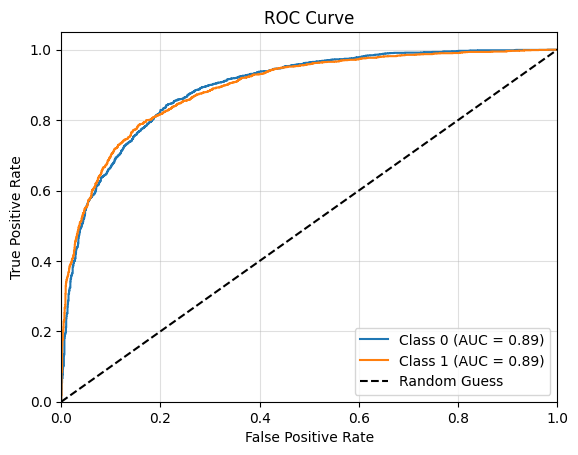

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

@torch.no_grad()
def plot_roc_curve(loader, model):
    model.eval()

    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        all_preds.append(logits.cpu())
        all_labels.append(data.y.cpu())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    one_hot_labels = torch.nn.functional.one_hot(all_labels, num_classes=all_preds.size(1)).float()
    for class_idx in range(all_preds.size(1)):
        fpr, tpr, _ = roc_curve(one_hot_labels[:, class_idx], all_preds[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()

plot_roc_curve(test_loader,model)

### Without Weight Decay

Epoch: 01, Loss: 0.7558, Train: 0.4899, Val: 0.5147, Test: 0.5008
Epoch: 02, Loss: 0.7291, Train: 0.7427, Val: 0.7381, Test: 0.7193
Epoch: 03, Loss: 0.6797, Train: 0.7601, Val: 0.7491, Test: 0.7329
Epoch: 04, Loss: 0.6435, Train: 0.7564, Val: 0.7729, Test: 0.7488
Epoch: 05, Loss: 0.6261, Train: 0.7802, Val: 0.7747, Test: 0.7535
Epoch: 06, Loss: 0.6154, Train: 0.7995, Val: 0.7766, Test: 0.7483
Epoch: 07, Loss: 0.6152, Train: 0.7729, Val: 0.7656, Test: 0.7334
Epoch: 08, Loss: 0.6261, Train: 0.8068, Val: 0.7894, Test: 0.7538
Epoch: 09, Loss: 0.6150, Train: 0.7308, Val: 0.7161, Test: 0.7002
Epoch: 10, Loss: 0.6240, Train: 0.7802, Val: 0.7839, Test: 0.7554
Epoch: 11, Loss: 0.6118, Train: 0.7592, Val: 0.7399, Test: 0.7287
Epoch: 12, Loss: 0.6122, Train: 0.7555, Val: 0.7143, Test: 0.7172
Epoch: 13, Loss: 0.6070, Train: 0.8159, Val: 0.8004, Test: 0.7637
Epoch: 14, Loss: 0.5949, Train: 0.7940, Val: 0.7875, Test: 0.7559
Epoch: 15, Loss: 0.5967, Train: 0.8242, Val: 0.7802, Test: 0.7582
Epoch: 16,

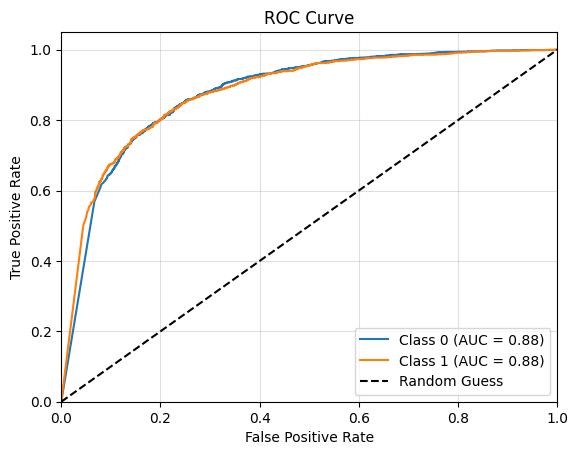

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(778, 256,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4,amsgrad=True)
for epoch in range(1, 200):
    loss = train(model)
    train_acc = test(train_loader, model)
    val_acc = test(val_loader, model)
    test_acc = test(test_loader, model)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
plot_roc_curve(test_loader,model)

As in the article: If we do not add weight decay (somehow equivalent to dropout) we overfit on the training but dail to genralize.